DIVA-4G
=======

## Introduction

The forth generation DIVA (DIVA-4G) will be primarily a library that allows to calculate flood risk and to find adaptation pathways. The DIVA model will then be a very short programm written based on the lirbrary. 

This library will be much more felxible than the "old" DIVA because it allwos to compute flood damages, risks and adapation pathways based on different spatio-temperal representations of floodplains, hazards, exposure, etc.

To start off, we will consider the following three different spatial representaions of floodplains:
- 2D gridded floodplain
- 1D gridded floodplain
- 1D vector floodplain

In terms of hazard we will consider:
- Static still extreme water level:
- Dynamic still extreme water levels: a hydrograph

In terms of flooding model, we may consider:
- Simple bathtub
- Tilted bathtub
- Flood intensitiy index
- 1D hydrodynamic model
- etc.

Flood risk = exposure * vulnerability * hazard


## Floodplain

### Abstarct type hirarchy

First, we introdcue a hirarchy of abtract types. 

In [1]:
abstract type FloodPlain end

abstract type FloodPlainGrid   <: FloodPlain end
abstract type FloodPlainGrid1d <: FloodPlainGrid end
abstract type FloodPlainGrid2d <: FloodPlainGrid end
abstract type FloodPlainVect   <: FloodPlain end

# print the type hirarchy
using AbstractTrees
AbstractTrees.children(d::DataType) = subtypes(d)
print_tree(FloodPlain)

FloodPlain
├─ FloodPlainGrid
│  ├─ FloodPlainGrid1d
│  └─ FloodPlainGrid2d
└─ FloodPlainVect


### Implementations of a couple of generic functions that operate on the abstract supertype FloodPlain

In [2]:
Base.getindex(fp::FloodPlain,s::Symbol) = getfield(fp,s)

### Type 1D gridded floodplain

In terms of developing the DIVA4G library it seems to me that it makes sense to start with 1D gridded floodplains, as the algorithms for these are simplest.

A simple implementation may look like the following:

In [3]:
struct FloodPlainGrid1dSimple <: FloodPlainGrid1d
    width::Float64
    x::Array{Float64}
    ele::Array{Float64}
    pop::Array{Float64}
end

# convenient constructors
FloodPlainGrid1dSimple(width,x,ele) = FloodPlainGrid1dSimple(width,x,ele,zeros(length(x)))

FloodPlainGrid1dSimple

In [4]:
# build example floodplain with 100 pixels

n =100
ele = sort(rand(Float64,n)).*4 .-1.5
x = collect(1:n)
width = 1.0
fp1D = FloodPlainGrid1dSimple(width,x,ele)

FloodPlainGrid1dSimple(1.0, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0], [-1.4889623584995801, -1.4321967572242316, -1.4222982971010465, -1.385938715734619, -1.3477925988175348, -1.322915544236365, -1.3176227887506027, -1.2712217306949065, -1.2542185742858045, -1.245512579201443  …  1.9347171203392461, 2.038163854286468, 2.194567817638676, 2.210422369938605, 2.22321872224524, 2.303136689906777, 2.311139406190771, 2.347701461417235, 2.369309714896704, 2.4597685857854885], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

I alos thing that it would be useful to implement plotting functions for each type of floodplain, because that helps illusatring the ideas and finding mistakes.

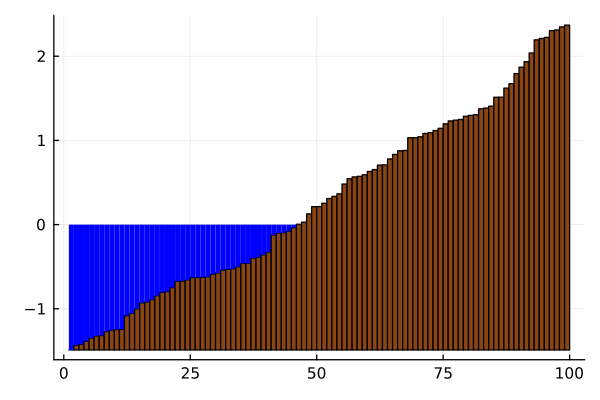

In [5]:
using Plots

function RecipesBase.plot(fp::FloodPlainGrid1d)
    p = plot(thickness_scaling=1.3,legend=false)
    for i in 1:length(fp.x)-1
        y = fp.ele[i]
        y_min = minimum(fp.ele)
        x,x_next = fp.x[i],fp.x[i+1]
        plot!(p,Shape([(x,y_min),(x,y),(x_next,y),(x_next,y_min)]),fill=:saddlebrown)
        if y<0 plot!(p,Shape([(x,0),(x,y),(x_next,y),(x_next,0)]),fill=:blue,linewidth=0) end
    end
    plot(p)
end

plot(fp1D)

### Alternative implementation of Type 1D gridded floodplain

Here is an alternative implementation using the StructArray, which provides a convenient was of accessing the data.

In [55]:
using StructArrays

struct FloodPlainGrid1dStructArray <: FloodPlainGrid1d
    width::Float64
    data::StructArray
end

# convenient constructors
FloodPlainGrid1dStructArray(width,data::NamedTuple) = FloodPlainGrid1dStructArray(width,StructArray(data))

# example floodplain
fp1D_sa = FloodPlainGrid1dStructArray(1.0,(x=[1,2,3], ele=[2,4,6], pop=[1000,1200,1400]))

FloodPlainGrid1dStructArray(1.0, NamedTuple{(:x, :ele, :pop), Tuple{Int64, Int64, Int64}}[(x = 1, ele = 2, pop = 1000), (x = 2, ele = 4, pop = 1200), (x = 3, ele = 6, pop = 1400)])

In [52]:
# convenient method for accessing values of one 
Base.getindex(fp::FloodPlainGrid1dStructArray,s::Symbol) = getproperty(fp.data,s)
fp1D_sa[:ele]

3-element Vector{Int64}:
 2
 4
 6

In [54]:
# the nice thing of StructArrays is that one can access all fields of a grid cell as a NamedTupple
Base.getindex(fp::FloodPlainGrid1dStructArray,i::Int64) = getindex(fp.data,i)
fp1D_sa[1]

(x = 1, ele = 2, pop = 1000)

## Quering floodplains


### Exposure below a given elevation

In [7]:
function exposed_area(fp::FloodPlainGrid1d,ele)
    expo_area = (fp.x - vcat(0.0,fp.x[1:end-1])) * fp.width
    sum(expo_area .* map(x->(x<ele)*1.0, fp.ele)) 
end

# Area below 2m elevation
exposed_area(fp1D,2)

91.0

In [8]:
const ExposureType = Symbol

function exposed(fp::FloodPlainGrid1d,field::ExposureType,ele)
    expo = getfield(fp,field)
    sum( expo .* map(x->(x<ele)*1.0, fp.ele))
end


# How many people are exposed to a water level of 2.5 m
exposed(fp1D,:pop,2.5)

0.0

## Manipulating floodplains

### Changing exposure

In [9]:
function move_exposure(fp::FloodPlainGrid1d, field::ExposureType, from, to)

end

move_expsoure(fp1D,:pop,(0,1),(1,2))

LoadError: UndefVarError: move_expsoure not defined

### Changing elevation

In [10]:
function raise_elevation(fp::FloodPlainGrid1d, from, to)

raise_elevation(fp,(0,1),(1,1)))

LoadError: syntax: "function" at In[10]:1 expected "end", got ")"

## Hazard

We distinguish between single hazard events and distributions of all possible hazard events.

### Hazard events

In [11]:
abstract type ExtremeEvent end

abstract type SurgeEvent <: ExtremeEvent end
abstract type WaveEvent  <: ExtremeEvent end
abstract type CompoundEvent  <: ExtremeEvent end

In [12]:
struct SurgeEventStatic{T} <: SurgeEvent
    esl::T
end

struct SurgeEventDynamic{T} <: SurgeEvent
    time::Vector{T}
    esl::Vector{T}
end

print_tree(ExtremeEvent)

ExtremeEvent
├─ CompoundEvent
├─ SurgeEvent
│  ├─ SurgeEventDynamic
│  └─ SurgeEventStatic
└─ WaveEvent


### Hazard distributions

## Flood models

In [13]:
abstract type FloodModel end

abstract type StaticFloodModel  <: FloodModel end
abstract type DynamicFloodModel <: FloodModel end

In [14]:
struct BathtubSimple <: StaticFloodModel end

In [15]:
function damage(fp::FloodPlainGrid1d,field::Symbol,e::SurgeEvent)
    exposed(fp,field,e)    ### Type 1D vector floodplain


LoadError: syntax: incomplete: "function" at In[15]:1 requires end

## Other type of floodpains

### 1D Vector Floodplain
A 1D vector floodplain is defined by a list of trapeziums. This is the struture we have always used in DIVA. The following shows an example implementation.


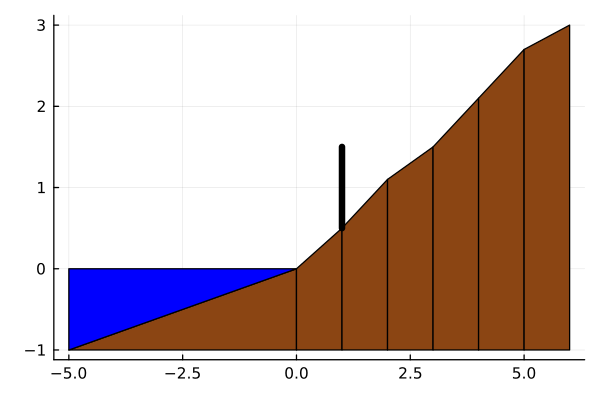

In [16]:
struct FloodPlainVectSimple{T} <: FloodPlainVect
    width::T
    x::Array{T}
    ele::Array{T}
    pop::Array{T}
    defense::Tuple{Int64,T}
end

# a couple of convenience constructors
FloodPlainVectSimple(width,x,ele)     = FloodPlainVectSimple(width,x,ele,zeros(length(x)),(2,1.0))
FloodPlainVectSimple(width,x,ele,def) = FloodPlainVectSimple(width,x,ele,zeros(length(x)),def)

# An example floodplain
x =         [-5.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0]
elevation = [-1.0,0.0,0.5,1.1,1.5,2.1,2.7,3.0]
width = 2.0
defense = (3,1.0)
fp = FloodPlainVectSimple(width,x,elevation,defense)

using Plots

function RecipesBase.plot(fp::FloodPlainVect) 
    p = plot(thickness_scaling=1.3,legend=false)
    # plot(fp.x,fp.ele,legend=false,color=:saddlebrown)
    for i in 1:length(fp.x)-1
        y,y_next = fp.ele[i],fp.ele[i+1]
        y_min = minimum(fp.ele)
        x,x_next = fp.x[i],fp.x[i+1]
        plot!(p,Shape([(x,y_min),(x,y),(x_next,y_next),(x_next,y_min)]),fill=:saddlebrown)
        if y<0
            plot!(p,Shape([(x,0),(x,y),(x_next,y_next),(x_next,0)]),fill=:blue,color=:blue)
        end
    end
    if fp.defense[2]>0
        i = fp.defense[1]
        x = fp.x[i]
        h = fp.defense[2]
        ele = fp.ele[i]
        plot!([x,x],[ele,ele+h],color=:black,linewidth=5)
    end
    plot(p)
end

plot(fp)